In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
# Carregar os dados
dados = pd.read_parquet("df_com_clusters_atualizados.parquet")

dados.

Index(['release_date', 'revenue', 'budget', 'runtime', 'genres',
       'original_language', 'production_countries', 'spoken_languages',
       'adult', 'cluster', 'clusters_n', 'disponibilidade_lucro', 'lucro',
       'classificacao', 'num_languages', 'idade', 'Action', 'Science Fiction',
       'Adventure', 'Drama', 'Crime', 'Thriller', 'Fantasy', 'Comedy',
       'Romance', 'Western', 'Mystery', 'War', 'Animation', 'Family', 'Horror',
       'Music', 'lang_de', 'lang_en', 'lang_es', 'lang_fr', 'lang_it',
       'lang_ja', 'lang_other_language', 'lang_pt', 'lang_zh',
       'country_Canada', 'country_China', 'country_France', 'country_Germany',
       'country_India', 'country_Italy', 'country_Japan', 'country_Spain',
       'country_United Kingdom', 'country_other_country', 'cluster_kmodes',
       'cluster_kmeans'],
      dtype='object')

In [2]:
import pandas as pd

def processar_dados(caminho_arquivo):
    # Carregar os dados
    dados = pd.read_parquet(caminho_arquivo)

    # Selecionar colunas relevantes
    dados = dados[["release_date", "revenue", "budget", "runtime", "genres", 
                  "original_language", "production_countries", "spoken_languages", "adult", "cluster", "clusters_n"]]

    # Filtrar dados (adult == False)
    dados = dados[dados["adult"] == False].copy()

    # Criar coluna 'disponibilidade_lucro'
    dados["disponibilidade_lucro"] = (
        dados["revenue"].apply(lambda x: isinstance(x, (int, float)) and x > 0) & 
        dados["budget"].apply(lambda x: isinstance(x, (int, float)) and x > 0)
    ).astype(int)

    

    # Eliminar registros com 'disponibilidade_lucro' igual a 0
    dados = dados[dados["disponibilidade_lucro"] == 1].copy()

    # Calcular 'lucro' e 'classificacao'
    dados['lucro'] = dados.apply(lambda row: row['revenue'] - row['budget']
                                 if isinstance(row['budget'], (int, float)) and isinstance(row['revenue'], (int, float))
                                 else None, axis=1)

    dados['classificacao'] = dados.apply(lambda row: 1 if row['lucro'] is not None and row['lucro'] > 0 and row['disponibilidade_lucro'] == 1 else 0, axis=1)
    

    # Criar o dataset 'dados_com_lucro' (classificacao == 1)
    dados_com_lucro = dados[dados['classificacao'] == 1]

    dados_com_lucro = dados_com_lucro[dados_com_lucro["budget"] >= 1000000]

    # Criar o dataset 'dados_sem_lucro' (classificacao == 0)
    dados_sem_lucro = dados[dados['classificacao'] == 0]

    # Criar duas amostras representativas de 'dados_com_lucro' (50% cada)
    metade_lucro_1 = dados_com_lucro.sample(frac=0.5, random_state=42)
    metade_lucro_2 = dados_com_lucro.drop(metade_lucro_1.index)  # O restante dos dados

    # Criar duas amostras representativas de 'dados_sem_lucro' (50% cada)
    metade_sem_lucro_1 = dados_sem_lucro.sample(frac=0.5, random_state=42)
    metade_sem_lucro_2 = dados_sem_lucro.drop(metade_sem_lucro_1.index)  # O restante dos dados

    # Concatenar as metades sem lucro com suas respectivas metades com lucro
    conjunto_1 = pd.concat([metade_lucro_1, metade_sem_lucro_1], ignore_index=True)
    conjunto_2 = pd.concat([metade_lucro_2, metade_sem_lucro_2], ignore_index=True)

    dados = pd.concat([conjunto_1, conjunto_2], ignore_index=True)

    
    
    return conjunto_1, conjunto_2


# Exemplo de uso
dados_teste_balanceado, dados_treino_balanceado = processar_dados("df_com_clusters_atualizados.parquet")


In [3]:

dados_teste = dados_teste_balanceado.copy()

dados_treino_filtrado = dados_treino_balanceado.copy()
# Criar novas colunas (número de idiomas e idade)
for df in [dados_treino_filtrado, dados_teste]:
    df["num_languages"] = df["spoken_languages"].apply(lambda x: len(x.split(",")) if isinstance(x, str) else 0)
    df["idade"] = df["release_date"].apply(lambda x: 2025 - int(x.split("-")[0]) if isinstance(x, str) else 0)

# Lista de gêneros
generos = ['Action', 'Science Fiction', 'Adventure', 'Drama', 'Crime',
           'Thriller', 'Fantasy', 'Comedy', 'Romance', 'Western', 'Mystery', 'War',
           'Animation', 'Family', 'Horror', 'Music']

def aplicar_one_hot_encoding_generos(df, generos):
    for genero in generos:
        df[genero] = df['genres'].apply(lambda x: 1 if isinstance(x, str) and genero in x.split(', ') else 0)
    return df

# Aplicar one-hot encoding de gêneros
dados_treino_filtrado = aplicar_one_hot_encoding_generos(dados_treino_filtrado, generos)
dados_teste = aplicar_one_hot_encoding_generos(dados_teste, generos)

def aplicar_one_hot_encoding_limitado(df, idiomas_permitidos, selected_countries):
    df['original_language_encoded'] = df['original_language']
    df['production_countries_encoded'] = df['production_countries']
    df['original_language_encoded'] = df['original_language_encoded'].apply(
        lambda x: x if x in idiomas_permitidos else 'other_language'
    )
    df['production_countries_encoded'] = df['production_countries_encoded'].apply(
        lambda x: x if x in selected_countries else 'other_country'
    )
    df = pd.get_dummies(df, columns=['original_language_encoded', 'production_countries_encoded'], prefix=['lang', 'country'])
    return df

# Listas de idiomas e países permitidos
idiomas_permitidos = ['en', 'fr', 'es', 'de', 'ja', 'zh', "pt", 'it']
selected_countries = ['United States of America', 'France', 'United Kingdom', 'Germany', 
                      'Canada', 'Japan', 'China', 'India', 'Italy', 'Spain']

# Aplicar one-hot encoding limitado
dados_treino_encoded = aplicar_one_hot_encoding_limitado(dados_treino_filtrado, idiomas_permitidos, selected_countries)
dados_teste_encoded = aplicar_one_hot_encoding_limitado(dados_teste, idiomas_permitidos, selected_countries)

# Garantir que a coluna 'genres' seja preservada
dados_treino_encoded['genres'] = dados_treino_filtrado['genres']
dados_teste_encoded['genres'] = dados_teste['genres']

# Alinhar colunas
dados_treino_encoded, dados_teste_encoded = dados_treino_encoded.align(dados_teste_encoded, join='outer', axis=1, fill_value=0)

dados_treino_encoded.to_parquet("dados_treino.parquet", index=False)
dados_teste_encoded.to_parquet("dados_teste.parquet", index=False)


 
dados = pd.concat([dados_treino_encoded, dados_teste_encoded], ignore_index=True)

print(len(dados))

unico = dados.drop_duplicates()

print(len(unico))

dados.columns





9296
9291


Index(['release_date', 'revenue', 'budget', 'runtime', 'genres',
       'original_language', 'production_countries', 'spoken_languages',
       'adult', 'cluster', 'clusters_n', 'disponibilidade_lucro', 'lucro',
       'classificacao', 'num_languages', 'idade', 'Action', 'Science Fiction',
       'Adventure', 'Drama', 'Crime', 'Thriller', 'Fantasy', 'Comedy',
       'Romance', 'Western', 'Mystery', 'War', 'Animation', 'Family', 'Horror',
       'Music', 'lang_de', 'lang_en', 'lang_es', 'lang_fr', 'lang_it',
       'lang_ja', 'lang_other_language', 'lang_pt', 'lang_zh',
       'country_Canada', 'country_China', 'country_France', 'country_Germany',
       'country_India', 'country_Italy', 'country_Japan', 'country_Spain',
       'country_United Kingdom', 'country_United States of America',
       'country_other_country'],
      dtype='object')

In [4]:
# Lista de colunas a serem removidas
colunas_para_remover = ["release_date", "revenue", "budget", "genres", "original_language", 
                        "production_countries", "spoken_languages", "adult", 
                        "disponibilidade_lucro", "lucro", "runtime", "idade","clusters_n", "cluster"]

# Aplicar a remoção corretamente
for i, df in enumerate([dados]):
    df = df.drop(columns=colunas_para_remover, errors='ignore')

    # Atribuir de volta ao DataFrame correto
    if i == 0:
        dados= df
    else:
        dados_treino_encoded = df

#dados_teste_encoded = dados_teste_encoded[["cluster", "clusters_n", "classificacao"]]
#dados_treino_encoded = dados_teste_encoded[["cluster", "clusters_n", "classificacao"]]

dados_teste_encoded.columns

Index(['release_date', 'revenue', 'budget', 'runtime', 'genres',
       'original_language', 'production_countries', 'spoken_languages',
       'adult', 'cluster', 'clusters_n', 'disponibilidade_lucro', 'lucro',
       'classificacao', 'num_languages', 'idade', 'Action', 'Science Fiction',
       'Adventure', 'Drama', 'Crime', 'Thriller', 'Fantasy', 'Comedy',
       'Romance', 'Western', 'Mystery', 'War', 'Animation', 'Family', 'Horror',
       'Music', 'lang_de', 'lang_en', 'lang_es', 'lang_fr', 'lang_it',
       'lang_ja', 'lang_other_language', 'lang_pt', 'lang_zh',
       'country_Canada', 'country_China', 'country_France', 'country_Germany',
       'country_India', 'country_Italy', 'country_Japan', 'country_Spain',
       'country_United Kingdom', 'country_United States of America',
       'country_other_country'],
      dtype='object')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Classification Report para Treino (SVM):
              precision    recall  f1-score   support

           0       0.67      0.40      0.50      2733
           1       0.66      0.85      0.75      3774

    accuracy                           0.67      6507
   macro avg       0.67      0.63      0.63      6507
weighted avg       0.67      0.67      0.65      6507


Classification Report para Teste (SVM):
              precision    recall  f1-score   support

           0       0.62      0.38      0.47      1171
           1       0.65      0.83      0.73      1618

    accuracy                           0.64      2789
   macro avg       0.63      0.60      0.60      2789
weighted avg       0.63      0.64      0.62      2789



100%|██████████| 100/100 [1:03:08<00:00, 37.89s/it]


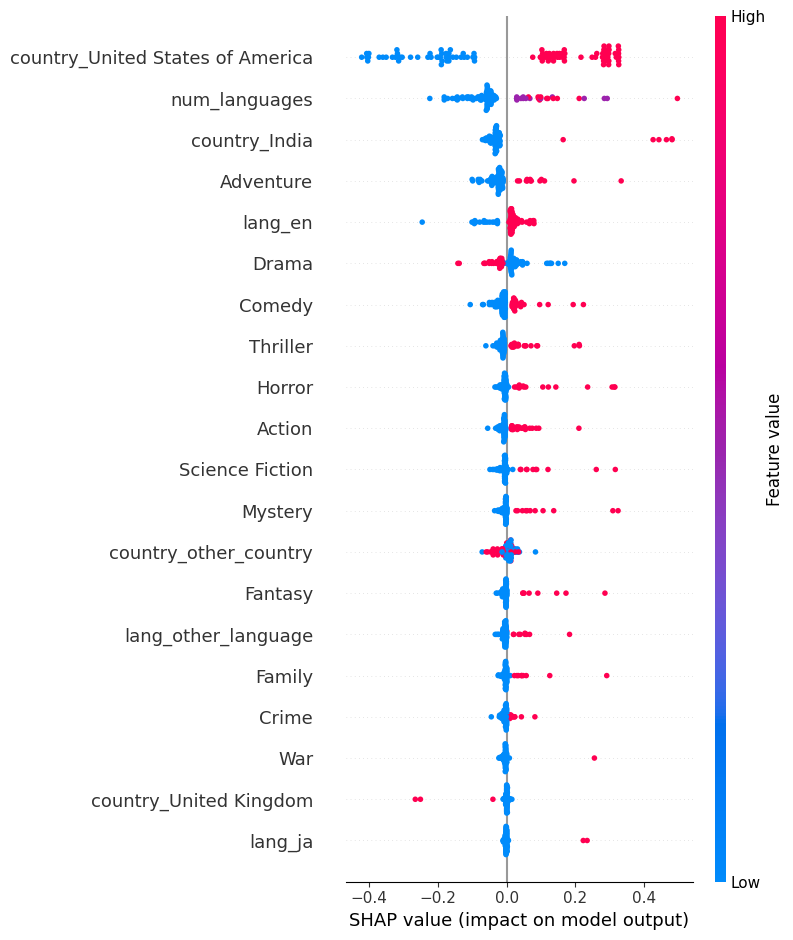

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
import numpy as np

# Separando features (X) e target (y)
X = dados.drop(columns=['classificacao'])
y = dados['classificacao']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Criando e treinando o modelo SVM
svm_model = SVC(kernel='rbf', C=0.5, gamma='scale')  # Removido probability=True
svm_model.fit(X_train, y_train)

# Fazendo previsões
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# Printando o classification report
print("Classification Report para Treino (SVM):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report para Teste (SVM):")
print(classification_report(y_test, y_test_pred))

# Aplicando SHAP para explicar as previsões usando KernelExplainer
sample_data = X_train.sample(n=100, random_state=42)  # Amostragem para reduzir custo computacional
explainer = shap.KernelExplainer(svm_model.predict, sample_data)
shap_values = explainer.shap_values(X_test.sample(n=100, random_state=42))

# Plotando a importância das features
shap.summary_plot(shap_values, X_test.sample(n=100, random_state=42))


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, recall_score

# Loop para encontrar o melhor valor de k com base no recall
melhor_k = None
melhor_recall = 0
for k in range(1, 21):  # Testando valores de k de 1 a 20
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_test_pred = knn_model.predict(X_test)
    recall = recall_score(y_test, y_test_pred)
    if recall > melhor_recall:
        melhor_recall = recall
        melhor_k = k

print(f"Melhor valor de k encontrado: {melhor_k}")
print(f"Melhor recall encontrado: {melhor_recall}")

# Treinando o modelo KNN com o melhor valor de k
knn_model = KNeighborsClassifier(n_neighbors=melhor_k)
knn_model.fit(X_train, y_train)

# Fazendo previsões com o melhor modelo
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)

# Printando o classification report para o melhor modelo
print("\nClassification Report para Treino (KNN com melhor k):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report para Teste (KNN com melhor k):")
print(classification_report(y_test, y_test_pred))

Melhor valor de k encontrado: 17
Melhor recall encontrado: 0.7564894932014833

Classification Report para Treino (KNN com melhor k):
              precision    recall  f1-score   support

           0       0.64      0.50      0.56      2733
           1       0.69      0.80      0.74      3774

    accuracy                           0.67      6507
   macro avg       0.67      0.65      0.65      6507
weighted avg       0.67      0.67      0.67      6507


Classification Report para Teste (KNN com melhor k):
              precision    recall  f1-score   support

           0       0.58      0.46      0.51      1171
           1       0.66      0.76      0.70      1618

    accuracy                           0.63      2789
   macro avg       0.62      0.61      0.61      2789
weighted avg       0.62      0.63      0.62      2789



In [7]:
from sklearn.ensemble import RandomForestClassifier

melhor_n_estimators = None
melhor_recall = 0
for n_estimators in range(10, 110, 10):  # Testando valores de n_estimators de 10 a 100, pulando de 10 em 10
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X_train, y_train)
    y_test_pred = rf_model.predict(X_test)
    recall = recall_score(y_test, y_test_pred)
    if recall > melhor_recall:
        melhor_recall = recall
        melhor_n_estimators = n_estimators

print(f"Melhor valor de n_estimators encontrado: {melhor_n_estimators}")
print(f"Melhor recall encontrado: {melhor_recall}")

# Treinando o modelo Random Forest com o melhor valor de n_estimators
rf_model = RandomForestClassifier(n_estimators=melhor_n_estimators, random_state=42)
rf_model.fit(X_train, y_train)

# Fazendo previsões com o melhor modelo
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Printando o classification report para o melhor modelo
print("\nClassification Report para Treino (Random Forest com melhor n_estimators):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report para Teste (Random Forest com melhor n_estimators):")
print(classification_report(y_test, y_test_pred))

Melhor valor de n_estimators encontrado: 40
Melhor recall encontrado: 0.7533992583436341

Classification Report para Treino (Random Forest com melhor n_estimators):
              precision    recall  f1-score   support

           0       0.80      0.63      0.70      2733
           1       0.77      0.88      0.82      3774

    accuracy                           0.78      6507
   macro avg       0.78      0.76      0.76      6507
weighted avg       0.78      0.78      0.77      6507


Classification Report para Teste (Random Forest com melhor n_estimators):
              precision    recall  f1-score   support

           0       0.56      0.43      0.48      1171
           1       0.64      0.75      0.69      1618

    accuracy                           0.62      2789
   macro avg       0.60      0.59      0.59      2789
weighted avg       0.61      0.62      0.61      2789



In [8]:
import xgboost as xgb

# Loop para encontrar o melhor valor de n_estimators com base no recall
melhor_n_estimators = None
melhor_recall = 0
for n_estimators in range(10, 110, 10):  # Testando valores de n_estimators de 10 a 100, pulando de 10 em 10
    xgb_model = xgb.XGBClassifier(n_estimators=n_estimators, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_test_pred = xgb_model.predict(X_test)
    recall = recall_score(y_test, y_test_pred)
    if recall > melhor_recall:
        melhor_recall = recall
        melhor_n_estimators = n_estimators

print(f"Melhor valor de n_estimators encontrado: {melhor_n_estimators}")
print(f"Melhor recall encontrado: {melhor_recall}")

# Treinando o modelo XGBoost com o melhor valor de n_estimators
xgb_model = xgb.XGBClassifier(n_estimators=melhor_n_estimators, random_state=42)
xgb_model.fit(X_train, y_train)

# Fazendo previsões com o melhor modelo
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Printando o classification report para o melhor modelo
print("\nClassification Report para Treino (XGBoost com melhor n_estimators):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report para Teste (XGBoost com melhor n_estimators):")
print(classification_report(y_test, y_test_pred))

Melhor valor de n_estimators encontrado: 30
Melhor recall encontrado: 0.8312731767614339

Classification Report para Treino (XGBoost com melhor n_estimators):
              precision    recall  f1-score   support

           0       0.71      0.45      0.55      2733
           1       0.68      0.87      0.77      3774

    accuracy                           0.69      6507
   macro avg       0.70      0.66      0.66      6507
weighted avg       0.69      0.69      0.67      6507


Classification Report para Teste (XGBoost com melhor n_estimators):
              precision    recall  f1-score   support

           0       0.63      0.40      0.49      1171
           1       0.66      0.83      0.73      1618

    accuracy                           0.65      2789
   macro avg       0.64      0.61      0.61      2789
weighted avg       0.64      0.65      0.63      2789

